In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import plotly.express as px
import seaborn as sns
pd.options.plotting.backend = "plotly"

from sklearn.preprocessing import LabelEncoder
import re   
import nltk  
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras import datasets

from sklearn.metrics import confusion_matrix
from keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#import dataset
df = pd.read_csv("/content/train.tsv", sep="\t" )
df = df[['initial_request','clarification_need']]
df['clarification_need'] = df['clarification_need'].map({1.0:'No clarification needed', 2.0:'No clarification needed', 3.0:'Clarification needed', 4.0:'Clarification needed'})
df.head()
     

,initial_request,clarification_need
0,Tell me about Obama family tree.,No clarification needed
1,Tell me about Obama family tree.,No clarification needed
2,Tell me about Obama family tree.,No clarification needed
3,Tell me about Obama family tree.,No clarification needed
4,Tell me about Obama family tree.,No clarification needed


In [ ]:
df.isna().sum()

initial_request       0
clarification_need    0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

initial_request       0
clarification_need    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4052 entries, 0 to 4051
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   initial_request     4052 non-null   object
 1   clarification_need  4052 non-null   object
dtypes: object(2)
memory usage: 63.4+ KB


In [ ]:
df.shape

(4052, 2)

In [ ]:
df.clarification_need.value_counts()

No clarification needed    2496
Clarification needed       1556
Name: clarification_need, dtype: int64

In [ ]:
fig = px.pie(df, names='clarification_need', title ='Pie Chart of Sentiments Category')
fig.show()

In [ ]:
max_words = 5000
max_len= 60

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transformai text ke sequence bi. bulat
    X = tokenizer.texts_to_sequences(text)
    # Mengurutkan pad sequence dengan panjang yang sama
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['initial_request'][0])
X, tokenizer = tokenize_pad_sequences(df['initial_request'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 Tell me about Obama family tree.
After Tokenization & Padding 
 [  3   2   1 173 174 175   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [ ]:
#saving tokenized data
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
y = pd.get_dummies(df['clarification_need'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)

Train Set -> (3241, 60) (3241, 2)
Validation Set -> (811, 60) (811, 2)


In [ ]:
# build Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(2, activation='softmax')
])

#compile model
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.9:
    #if (logs.get('acc')> 0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached more than 90%!")
callbacks = myCallback()

In [ ]:
# Train model
batch_size = 32
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size, 
                    epochs=30, 
                    verbose=1, 
                    callbacks=[callbacks], 
                    validation_steps=30)

Epoch 1/30
102/102 [==============================] - ETA: 0s - loss: 1.1112e-06 - accuracy: 1.0000
The accuracy of the training set and the validation set has reached more than 90%!
102/102 [==============================] - 5s 45ms/step - loss: 1.1112e-06 - accuracy: 1.0000


In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc') > 0.95 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached more than 90%!")
callbacks = myCallback()


class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('acc') > 0.99):
                print("\n Reached 99% Accuracy!")
                self.model.stop_training = True

26/26 [==============================] - 1s 10ms/step


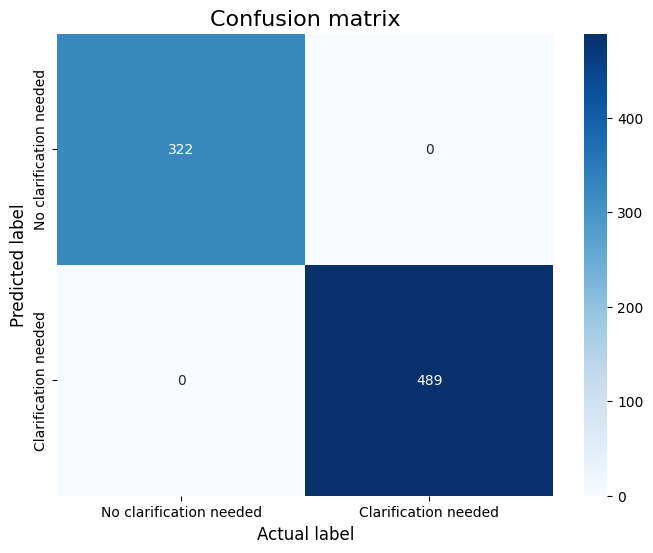

In [ ]:
#Model Confussion Matrix
def plot_confusion_matrix(model, X_, y_test):
    
    sentiment_classes = ['No clarification needed', 'Clarification needed']
    y_pred = model.predict(X_val)
    cm = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_val, y_val)
     

In [ ]:
#Model save and load for the prediction
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [ ]:
# Load model
model = load_model('best_model.h5')

def predict_class(text):
    
    sentiment_classes = ['No clarification needed', 'Clarification needed']
    max_len=50
    
    xt = tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted need is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['Tell me about Obama family tree.'])

1/1 [==============================] - 0s 78ms/step
The predicted need is Clarification needed
